**Import Necessary libraries**

In [1]:
import os
import math 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warning messages to ensure clean outputs
import warnings
warnings.filterwarnings('ignore')

**Data Preparation and Feature Selection**

In [2]:
df = pd.read_csv('cleaned_data_videoGames.csv')
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1351 entries, 0 to 1350
Data columns (total 14 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Name          1351 non-null   object 
 1   Platform      1351 non-null   object 
 2   Year          1351 non-null   int64  
 3   Genre         1351 non-null   object 
 4   Publisher     1351 non-null   object 
 5   NA_ Sales     1351 non-null   float64
 6   EU_Sales      1351 non-null   float64
 7   JP_Sales      1351 non-null   float64
 8   Other_Sales   1351 non-null   float64
 9   Global_Sales  1351 non-null   float64
 10  Critic_Score  1351 non-null   float64
 11  User_Score    1351 non-null   float64
 12  Rating        1350 non-null   object 
 13  Total_Sales   1351 non-null   float64
dtypes: float64(8), int64(1), object(5)
memory usage: 147.9+ KB


In [4]:
# Check for missing data
print(df.isnull().sum())


Name            0
Platform        0
Year            0
Genre           0
Publisher       0
NA_ Sales       0
EU_Sales        0
JP_Sales        0
Other_Sales     0
Global_Sales    0
Critic_Score    0
User_Score      0
Rating          1
Total_Sales     0
dtype: int64


**Feature Engineering**

In [5]:
# Creating a new feature "Total_Critic_Score" by adding Critic_Score and User_Score
df['Total_Critic_Score'] = df['Critic_Score'] + df['User_Score']

# Creating a new feature "Sales_Per_Year" by dividing Global_Sales by Year
df['Sales_Per_Year'] = df['Global_Sales'] / df['Year']


In [6]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df['Platform_Encoded']=le.fit_transform(df['Platform'])
df['Genre_Encoded'] = le.fit_transform(df['Genre'])
df['Rating_Encoded'] = le.fit_transform(df['Rating'])

In [7]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74,84.0,0.041246,14,10,0
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83,90.3,0.017839,14,6,0
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00,88.0,0.016426,14,10,0
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01,97.5,0.014960,2,4,0
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01,64.6,0.014467,14,3,0


In [8]:
# Using StandardScaler to scale the numerical feature "Global_Sales"
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
df['Global_Sales_Scaled'] = scaler.fit_transform(df[['Global_Sales']])


In [9]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Rating,Total_Sales,Total_Critic_Score,Sales_Per_Year,Platform_Encoded,Genre_Encoded,Rating_Encoded,Global_Sales_Scaled
0,Wii Sports,Wii,2006,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74,76.0,8.0,E,82.74,84.0,0.041246,14,10,0,21.280205
1,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82,82.0,8.3,E,35.83,90.3,0.017839,14,6,0,8.796565
2,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00,80.0,8.0,E,33.00,88.0,0.016426,14,10,0,8.046269
3,New Super Mario Bros.,DS,2006,Platform,Nintendo,11.38,9.23,6.50,2.90,30.01,89.0,8.5,E,30.01,97.5,0.014960,2,4,0,7.250743
4,Wii Play,Wii,2006,Misc,Nintendo,14.03,9.20,2.93,2.85,29.02,58.0,6.6,E,29.01,64.6,0.014467,14,3,0,6.987342


**Applying the Machine Learning models:**

In [20]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.model_selection import validation_curve

In [27]:
df_dummies = pd.get_dummies(df, columns=['Name','Platform', 'Publisher','Rating'])


# Define your features and target variable
X = df_dummies.drop('Genre', axis=1) # Drop the target variable
y = df_dummies['Genre']
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

df_dummies.head()

,Year,Genre,NA_ Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales,Critic_Score,User_Score,Total_Sales,...,Publisher_Valve Software,Publisher_Virgin Interactive,Publisher_Vivendi Games,Publisher_Warner Bros. Interactive Entertainment,Publisher_Zoo Digital Publishing,Publisher_Zoo Games,Rating_E,Rating_E10+,Rating_M,Rating_T
0,2006,Sports,41.49,29.02,3.77,8.46,82.74,76.0,8.0,82.74,...,0,0,0,0,0,0,1,0,0,0
1,2008,Racing,15.85,12.88,3.79,3.31,35.82,82.0,8.3,35.83,...,0,0,0,0,0,0,1,0,0,0
2,2009,Sports,15.75,11.01,3.28,2.96,33.00,80.0,8.0,33.00,...,0,0,0,0,0,0,1,0,0,0
3,2006,Platform,11.38,9.23,6.50,2.90,30.01,89.0,8.5,30.01,...,0,0,0,0,0,0,1,0,0,0
4,2006,Misc,14.03,9.20,2.93,2.85,29.02,58.0,6.6,29.01,...,0,0,0,0,0,0,1,0,0,0


**Logistic Regression**

In [55]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

logreg = LogisticRegression(random_state=42)
logreg.fit(X_train, y_train)

acc_logreg = logreg.score(X_test, y_test)
print('Logistic Regression accuracy:', acc_logreg)

Logistic Regression accuracy: 0.6678966789667896


In [57]:
from sklearn.metrics import confusion_matrix

cnf_matrix = confusion_matrix(y_test, logreg.predict(X_test))
print(cnf_matrix)

Accuracy_lr=logreg.score(X_test,y_test)

print(Accuracy_lr)

[[64  0  0  0  0  0  0  0  0  0  0  0]
 [ 3  0  0  0  0  0  0  0  0  0  0  0]
 [ 6  0  4  3  1  0  0  0  0  0  0  0]
 [ 0  0  4 14  3  0  0  0  0  0  0  0]
 [ 0  0  2  4 12  0  5  2  1  0  0  0]
 [ 0  0  0  1  1  0  0  2  0  0  0  0]
 [ 0  0  0  2  0  0  8  2  5  1  0  0]
 [ 0  0  0  0  0  0  3 11  4  0  0  0]
 [ 0  0  0  0  0  0  4 13 29  0  4  0]
 [ 0  0  0  0  0  0  0  3  3  2  2  0]
 [ 0  0  0  0  0  0  0  3  2  0 37  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0]]
0.6678966789667896


In [58]:
cv_scores = cross_val_score(logreg, X, y, cv=5, scoring='accuracy')
print(cv_scores_test)
cv_scores_lr_test= cv_scores_test.mean()
cv_scores_lr_train= cv_scores_train.mean()
cv_scores_std_test_lr= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_lr_test))
print ('Mean cross validation train score: ' +str(cv_scores_lr_train))
print ('Standard deviation in cv test scores: ' +str(cv_scores_std_test_lr))


[0.81818182 0.85185185 0.77777778 0.7037037  0.85185185]
Mean cross validation test score: 0.8006734006734006
Mean cross validation train score: 0.9277777777777778
Standard deviation in cv test scores: 0.0556279499745815


**K-Nearest Neighbor**

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)
Accuracy_knn=knn.score(X_test,y_test)

print(Accuracy_knn)
#knn_disp= plot_roc_curve(knn,X_test,y_test)


from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

print("Accuracy:", knn.score(X_test, y_test))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

0.7158671586715867
Accuracy: 0.7158671586715867
Confusion Matrix:
 [[56  0  2  1  1  0  1  0  2  0  1  0]
 [ 1  0  1  0  1  0  0  0  0  0  0  0]
 [ 2  0 10  0  0  0  0  1  1  0  0  0]
 [ 2  0  0 11  6  0  1  0  0  1  0  0]
 [ 3  0  0  3 16  0  4  0  0  0  0  0]
 [ 0  0  0  0  1  2  0  1  0  0  0  0]
 [ 2  0  0  1  2  0 11  0  0  1  1  0]
 [ 1  0  1  2  0  0  1  9  4  0  0  0]
 [ 8  0  0  1  0  0  2  1 38  0  0  0]
 [ 1  0  0  0  0  0  0  0  3  6  0  0]
 [ 1  0  0  0  0  0  1  0  4  0 35  1]
 [ 0  0  0  0  0  0  1  0  0  0  0  0]]
Classification Report:
               precision    recall  f1-score   support

      Action       0.73      0.88      0.79        64
   Adventure       0.00      0.00      0.00         3
    Fighting       0.71      0.71      0.71        14
        Misc       0.58      0.52      0.55        21
    Platform       0.59      0.62      0.60        26
      Puzzle       1.00      0.50      0.67         4
      Racing       0.50      0.61      0.55        18
Role-Pl

In [61]:
cv_scores_test= cross_val_score(knn,X_test,y_test,cv=5,scoring='accuracy')
cv_scores_train= cross_val_score(knn,X_train,y_train,cv=5,scoring='accuracy')
print(cv_scores_test)
cv_scores_knn_test= cv_scores_test.mean()
cv_scores_knn_train= cv_scores_train.mean()
cv_scores_std_knn= cv_scores_test.std()
print ('Mean cross validation test: ' +str(cv_scores_knn_test))
print ('Mean cross validation train: ' +str(cv_scores_knn_train))
print ('Standard deviation in cv: ' +str(cv_scores_std_knn))

[0.69090909 0.62962963 0.48148148 0.55555556 0.57407407]
Mean cross validation test: 0.5863299663299663
Mean cross validation train: 0.6611111111111112
Standard deviation in cv: 0.07057213354876475


**Support Vector Machine**

In [46]:
svm = SVC(kernel='rbf')
svm.fit(X_train, y_train)

# Predict using model:

y_predict_svm=svm.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_svm)
print(cnf_matrix)

Accuracy_svm=svm.score(X_test,y_test)
print(Accuracy_svm)

[[63  0  1  0  0  0  0  0  0  0  0  0]
 [ 2  0  0  1  0  0  0  0  0  0  0  0]
 [ 4  0 10  0  0  0  0  0  0  0  0  0]
 [ 3  0  0 13  4  0  1  0  0  0  0  0]
 [ 1  0  0  2 17  0  5  0  1  0  0  0]
 [ 0  0  0  1  0  0  2  1  0  0  0  0]
 [ 0  0  0  0  1  0 13  0  4  0  0  0]
 [ 0  0  0  0  1  0  0 11  6  0  0  0]
 [ 0  0  0  0  0  0  2  0 48  0  0  0]
 [ 0  0  0  0  0  0  0  0  5  5  0  0]
 [ 0  0  0  0  0  0  0  1  5  0 36  0]
 [ 0  0  0  0  0  0  0  0  0  1  0  0]]
0.7970479704797048


In [47]:
cv_scores_test= cross_val_score(svm,X_test,y_test,cv=5,scoring='accuracy')
cv_scores_train= cross_val_score(svm,X_train,y_train,cv=5,scoring='accuracy')
print(cv_scores_test)
cv_scores_svm_test= cv_scores_test.mean()
cv_scores_svm_train= cv_scores_train.mean()
cv_scores_std_svm= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_svm_test))
print ('Mean cross validation train score: ' +str(cv_scores_svm_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_svm))

[0.65454545 0.64814815 0.57407407 0.59259259 0.62962963]
Mean cross validation test score: 0.6197979797979798
Mean cross validation train score: 0.6935185185185184
Standard deviation in cv scores: 0.031427978085982966


**Random Forest**

In [63]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import classification_report

# Random Forest Classifier with Grid Search and Cross Validation
rf = RandomForestClassifier()

# Hyperparameters to search over
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# Create a GridSearchCV object with the specified hyperparameters
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5)

# Fit the GridSearchCV object to your training data
grid_search.fit(X_train, y_train)

# Get the best random forest model from the grid search
rf = grid_search.best_estimator_

# Feature Importance
feature_importances = pd.Series(rf.feature_importances_, index=pd.DataFrame(X_train).columns)
feature_importances.sort_values(ascending=False, inplace=True)
print(feature_importances)

# Model Evaluation
y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
Accuracy_rf=rf.score(X_test,y_test)
print(Accuracy_rf)

12     0.196342
9      0.033920
13     0.033513
3      0.032626
2      0.032374
         ...   
147    0.000000
323    0.000000
699    0.000000
143    0.000000
771    0.000000
Length: 1076, dtype: float64
              precision    recall  f1-score   support

      Action       0.90      1.00      0.95        64
   Adventure       0.00      0.00      0.00         3
    Fighting       0.90      0.64      0.75        14
        Misc       0.89      0.81      0.85        21
    Platform       0.96      0.85      0.90        26
      Puzzle       1.00      0.50      0.67         4
      Racing       0.71      0.67      0.69        18
Role-Playing       0.72      0.72      0.72        18
     Shooter       0.73      0.90      0.80        50
  Simulation       0.88      0.70      0.78        10
      Sports       0.93      0.88      0.90        42
    Strategy       0.00      0.00      0.00         1

    accuracy                           0.84       271
   macro avg       0.72      0.64    

In [64]:

cv_scores_test= cross_val_score(rf,X_test,y_test,cv=5,scoring='accuracy')
cv_scores_train= cross_val_score(rf,X_train,y_train,cv=5,scoring='accuracy')
print(cv_scores_test)
cv_scores_rf_test= cv_scores_test.mean()
cv_scores_rf_train= cv_scores_train.mean()
cv_scores_std_rf= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_rf_test))
print ('Mean cross validation train score: ' +str(cv_scores_rf_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_rf))

[0.70909091 0.7037037  0.61111111 0.66666667 0.62962963]
Mean cross validation test score: 0.664040404040404
Mean cross validation train score: 0.725925925925926
Standard deviation in cv scores: 0.03897495104913538


**Gradient Boosting**

In [39]:
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
gbc = GradientBoostingClassifier(subsample=0.8, learning_rate=0.05 , n_estimators=160, random_state=5, max_depth=9, max_leaf_nodes=100)
gbc.fit(X_train, y_train)

#Predict using the model:

y_predict_gbc = gbc.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_gbc)
print(cnf_matrix)
Accuracy_gbc=gbc.score(X_test,y_test)
print(Accuracy_gbc)

[[64  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  1  0  0  0  2  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0]
 [ 0  0  0 21  0  0  0  0  0  0  0  0]
 [ 0  0  0  0 26  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  4  0  0  0  0  0  0]
 [ 0  0  0  0  0  0 18  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 18  0  0  0  0]
 [ 0  0  0  0  0  0  0  0 50  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 10  0  0]
 [ 0  0  0  0  0  0  0  0  0  0 42  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  1]]
0.992619926199262


In [41]:
cv_scores_test= cross_val_score(gbc,X_test,y_test,cv=5,scoring='accuracy')
cv_scores_train= cross_val_score(gbc,X_train,y_train,cv=5,scoring='accuracy')
print(cv_scores_test)
cv_scores_gbc_test= cv_scores_test.mean()
cv_scores_gbc_train= cv_scores_train.mean()
cv_scores_std_gbc= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_gbc_test))
print ('Mean cross validation train score: ' +str(cv_scores_gbc_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_gbc))

[0.87272727 0.83333333 0.92592593 0.75925926 0.87037037]
Mean cross validation test score: 0.8523232323232323
Mean cross validation train score: 0.987037037037037
Standard deviation in cv scores: 0.05510154246148219


**Naive Bayes**

In [52]:
from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb.fit(X_train,y_train)

#Predict using the model:

y_predict_nb=nb.predict(X_test)

#Confusion matrix:

cnf_matrix = confusion_matrix(y_test, y_predict_nb)
print(cnf_matrix)
Accuracy_nb=nb.score(X_test,y_test)
print(Accuracy_nb)

[[64  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  3  0  0  0  0  0  0  0  0  0  0]
 [ 0  0 14  0  0  0  0  0  0  0  0  0]
 [ 1  0  0 19  0  0  1  0  0  0  0  0]
 [ 1  0  0  1 21  0  0  3  0  0  0  0]
 [ 0  0  0  0  0  3  1  0  0  0  0  0]
 [ 0  0  0  0  0  0 17  1  0  0  0  0]
 [ 0  0  0  0  0  0  0 17  1  0  0  0]
 [ 0  0  0  0  0  0  1  0 49  0  0  0]
 [ 0  0  0  0  0  0  0  0  2  8  0  0]
 [ 0  0  0  0  0  0  1  0  0  0 41  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0]]
0.9446494464944649


In [53]:
cv_scores_test= cross_val_score(nb,X_test,y_test,cv=5,scoring='accuracy')
cv_scores_train= cross_val_score(nb,X_train,y_train,cv=5,scoring='accuracy')
print(cv_scores_test)
cv_scores_nb_test= cv_scores_test.mean()
cv_scores_nb_train= cv_scores_train.mean()
cv_scores_std_nb= cv_scores_test.std()
print ('Mean cross validation test score: ' +str(cv_scores_nb_test))
print ('Mean cross validation train score: ' +str(cv_scores_nb_train))
print ('Standard deviation in cv scores: ' +str(cv_scores_std_nb))

[0.81818182 0.85185185 0.77777778 0.7037037  0.85185185]
Mean cross validation test score: 0.8006734006734006
Mean cross validation train score: 0.9277777777777778
Standard deviation in cv scores: 0.0556279499745815


**Comparison of the Models**

In [65]:
myLabels = [ 'Logistic Regression','KNN','SVM','Random Forest','Gradient Boost', 'Naive Bayes']
score_test= [  cv_scores_lr_test,cv_scores_knn_test,cv_scores_svm_test,cv_scores_rf_test,cv_scores_gbc_test,cv_scores_nb_test]
score_train= [  cv_scores_lr_train,cv_scores_knn_train,cv_scores_svm_train,cv_scores_rf_train,cv_scores_gbc_train,cv_scores_nb_train]
Accuracy_score = [Accuracy_lr,Accuracy_knn,Accuracy_svm,Accuracy_rf,Accuracy_gbc,Accuracy_nb]

score_tab_acc = pd.DataFrame(list(zip(myLabels, Accuracy_score)), 
               columns =['Algorithm', 'Model accuracy score']) 

score_tab = pd.DataFrame(list(zip(myLabels, score_train, score_test)), 
               columns =['Algorithm', 'Cross Validation precision train score', 'Cross Validation precision test score' ]) 
print(score_tab_acc)

score_tab

             Algorithm  Model accuracy score
0  Logistic Regression              0.667897
1                  KNN              0.715867
2                  SVM              0.797048
3        Random Forest              0.841328
4       Gradient Boost              0.992620
5          Naive Bayes              0.944649


,Algorithm,Cross Validation precision train score,Cross Validation precision test score
0,Logistic Regression,0.927778,0.800673
1,KNN,0.661111,0.586330
2,SVM,0.693519,0.619798
3,Random Forest,0.725926,0.664040
4,Gradient Boost,0.987037,0.852323
5,Naive Bayes,0.927778,0.800673


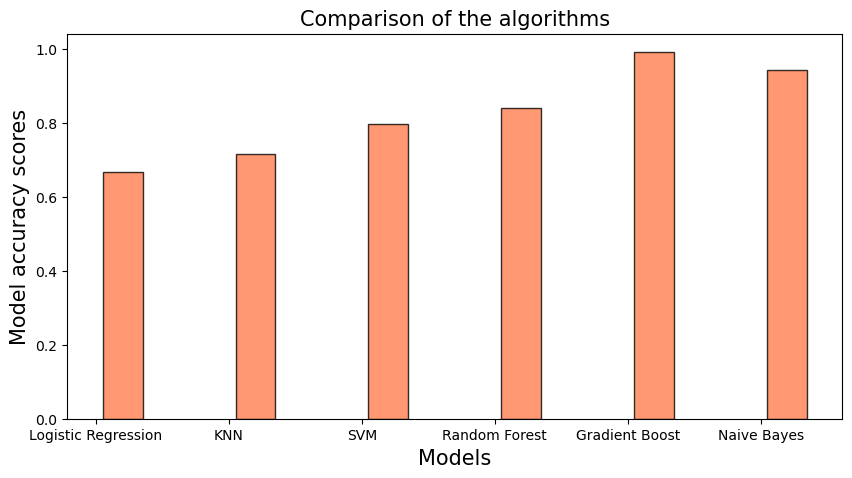

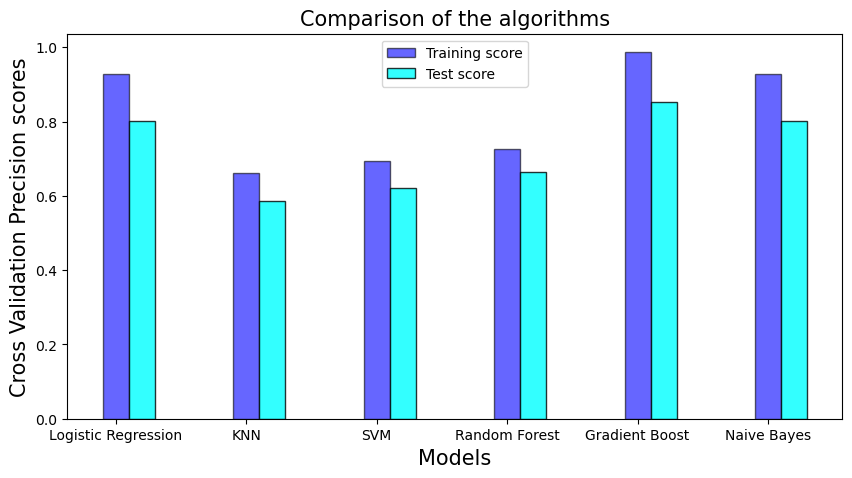

In [66]:
index=[1,2,3,4,5,6]
index_acc=[1.2,2.2,3.2,4.2,5.2,6.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Model accuracy scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
#patterns = [ "/"]
_=plt.bar(index_acc,Accuracy_score,color='coral',alpha=0.8,label='Accuracy score',edgecolor='k',width=0.3)
plt.xticks([1, 2,3,4,5,6], myLabels)
#plt.legend()
plt.savefig("26.png")
plt.show()



index=[1,2,3,4,5,6]
index_acc=[1.2,2.2,3.2,4.2,5.2,6.2]
plt.figure(figsize=(10,5))
plt.xlabel('Models',fontsize=15)
plt.ylabel ('Cross Validation Precision scores',fontsize=15)
plt.title('Comparison of the algorithms',fontsize=15)
_=plt.bar(index,score_train,color='b',alpha=0.6,label='Training score',edgecolor='k',width=0.2)
_=plt.bar(index_acc,score_test,color='cyan',alpha=0.8,label='Test score',edgecolor='k',width=0.2)
plt.xticks([1, 2,3,4,5,6], myLabels)
plt.legend()
plt.savefig("27.png")
plt.show()

**Parameter Tuning for Gradient Boost:**

In [68]:
from sklearn.model_selection import RandomizedSearchCV

GB = GradientBoostingClassifier()
gb_param = {
        'loss' : ["deviance"],
        'n_estimators' : [100,200,300],
        'learning_rate': [0.1, 0.05, 0.01],
        'max_depth': [4, 8],
        'min_samples_leaf': [100,150],
        'max_features': [0.3, 0.1] 
        }

gsGB = RandomizedSearchCV(estimator=GB, param_distributions=gb_param, cv=3, scoring="accuracy", n_jobs= -1, verbose = 1, n_iter=10)
gsGB.fit(X_train,y_train)

print(gsGB.best_estimator_)
print(gsGB.best_score_)


Fitting 3 folds for each of 10 candidates, totalling 30 fits
GradientBoostingClassifier(loss='deviance', max_depth=8, max_features=0.3,
                           min_samples_leaf=100, n_estimators=300)
0.987037037037037


**Fitting the Gradient Boost model with the optimal hyperparameters:**

In [71]:
GB= GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=8,
              max_features=0.3, max_leaf_nodes=None,
              min_impurity_decrease=0.0,
              min_samples_leaf=100, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=300,
              random_state=None, subsample=1.0, verbose=0,
              warm_start=False)
GB.fit(X_train, y_train)
y_predictions_GB = GB.predict(X_test)
acc_GB = accuracy_score(y_test, y_predictions_GB)
cv_GB = cross_val_score(GB, X_test, y_test,scoring='accuracy').mean()
print(acc_GB)
print(cv_GB)

0.992619926199262
0.4609427609427609


In [72]:
output = pd.DataFrame({'Actual': y_test, 'Predicted': y_predictions_GB})
output.to_csv('final_result_gb.csv', index=False, header=True)

In [82]:
columns = X
importances = list(GB.feature_importances_)
imp=np.sort(importances)
tab=pd.DataFrame(list(zip(X,imp)),columns =['Columns', 'Importance scores']) 
print(tab)


                  Columns  Importance scores
0                    Year           0.000000
1               NA_ Sales           0.000000
2                EU_Sales           0.000000
3                JP_Sales           0.000000
4             Other_Sales           0.000000
...                   ...                ...
1071  Publisher_Zoo Games           0.013787
1072             Rating_E           0.018919
1073          Rating_E10+           0.030990
1074             Rating_M           0.065955
1075             Rating_T           0.797339

[1076 rows x 2 columns]


In [84]:
print(tab)

                  Columns  Importance scores
0                    Year           0.000000
1               NA_ Sales           0.000000
2                EU_Sales           0.000000
3                JP_Sales           0.000000
4             Other_Sales           0.000000
...                   ...                ...
1071  Publisher_Zoo Games           0.013787
1072             Rating_E           0.018919
1073          Rating_E10+           0.030990
1074             Rating_M           0.065955
1075             Rating_T           0.797339

[1076 rows x 2 columns]


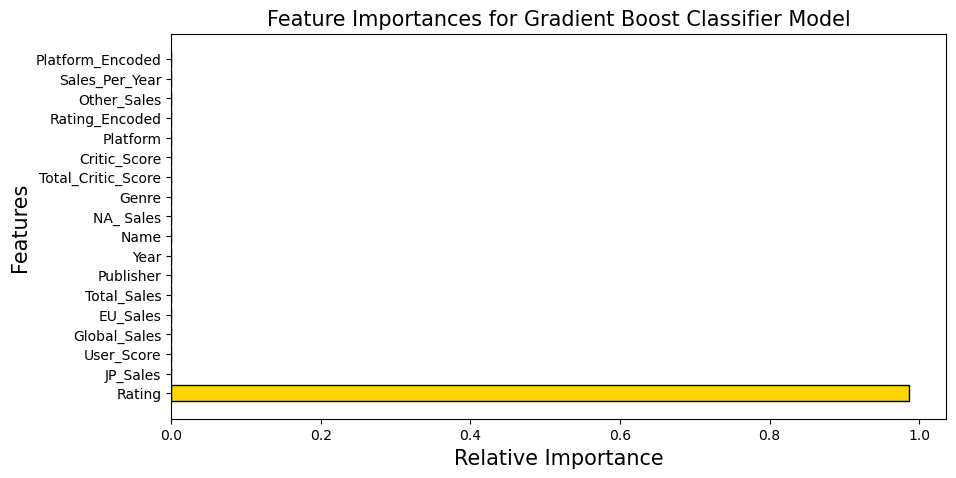

In [110]:
# fit the GradientBoostingClassifier model
model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, y_train)

# extract feature importances
importances = importances[:len(df.columns)]
indices = np.argsort(importances)[::-1]

# select the top n features
n = 18
indices = indices[:n]
index = np.arange(n)
imp = importances[indices]
features = np.array(df.columns)[indices]

# plot feature importances
plt.figure(figsize=(10,5))
_ = plt.barh(index, imp, align='center', color='gold', edgecolor='k')
plt.xlabel('Relative Importance', fontsize=15)
plt.ylabel('Features', fontsize=15)
plt.yticks(index, features)
plt.title('Feature Importances for Gradient Boost Classifier Model', fontsize=15)
plt.savefig("29.png")
plt.show()



In [109]:
print(df.columns.shape) 
print(importances.shape)

(20,)
(1076,)


**ROC-AUC Score and the ROC curve:**

ValueError: multi_class must be in ('ovo', 'ovr')

**Conclusion**